# Libraries

In [27]:
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from pathlib import Path
import sys

root = str(Path().resolve().parent)
if root not in sys.path:
    sys.path.append(root)
print(*sys.path, sep="\n")

# %matplotlib ipympl
%matplotlib inline

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


In [37]:
from importlib import reload
from rfdsppy import calc, ofdm, rf_analog as rfa, rf_tx_fw, tonegen, digital_filter_design, rx_dfe_impcomp as rx_impcomp, digital_hw_algo as dighw

reload(calc)
reload(ofdm)
reload(rfa)
reload(rf_tx_fw)
reload(tonegen)
reload(digital_filter_design)
reload(rx_impcomp)
reload(dighw)

<module 'rfdsppy.digital_hw_algo' from '/home/ryanwtsai/repos/rfdsp_sim/python/rfdsppy/digital_hw_algo.py'>

# CORDIC

In [47]:
# Generate sample waveform

nsym = 14
modorder = 4
bw = 20
scs = 15
num_sc = 1200
start_sc = 600-round(num_sc/2)
en_tprecode = False
osr = 1
wola = 1
# sig_frac_bits = 15
# sig_power = -19
wg = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc=num_sc, en_tprecode=en_tprecode, osr=osr, wola=wola)

x, x_standard = wg.generate(nsym)
cfg = wg.get_demod_params()
fs = cfg.get("fs")
wola_len = cfg.get("wola_len")

In [48]:
N = 16
cordic = dighw.CORDIC(N, "vectoring")
print(cordic.N)
print(cordic.mode)
print(cordic.sim_type)
print(cordic.K_)
print(cordic.theta_i_)
print(cordic.rot_mat_m_[-1])
print(cordic.rot_mat_p_[-1])

16
vectoring
vectorized
0.6072529351031394
[7.85398163e-01 4.63647609e-01 2.44978663e-01 1.24354995e-01
 6.24188100e-02 3.12398334e-02 1.56237286e-02 7.81234106e-03
 3.90623013e-03 1.95312252e-03 9.76562190e-04 4.88281211e-04
 2.44140620e-04 1.22070312e-04 6.10351562e-05 3.05175781e-05]
[[ 1.00000000e+00  3.05175781e-05]
 [-3.05175781e-05  1.00000000e+00]]
[[ 1.00000000e+00 -3.05175781e-05]
 [ 3.05175781e-05  1.00000000e+00]]


In [ ]:
env, ph = cordic.transform(x.real, x.imag)
x_polar = env*np.exp(-1j*ph) # for some reason I am getting the conjugate. I guess I rotated through the phase accumulation, so the acutla phase is the negative

In [79]:
np.sum(np.abs(x_polar-x)**2)
# np.sum(np.abs(x_polar)**2)
# np.sum(np.abs(x)**2)

np.float64(2.1870709758724946e-05)

In [80]:
rng = np.random.default_rng()

In [85]:


i = round(rng.uniform(low=0, high=x.size))

print(np.round(x[i],5))
print(np.round(x_polar[i],5))

(-0.01027+0.01244j)
(-0.01027+0.01244j)


np.float64(0.12496795880546298)

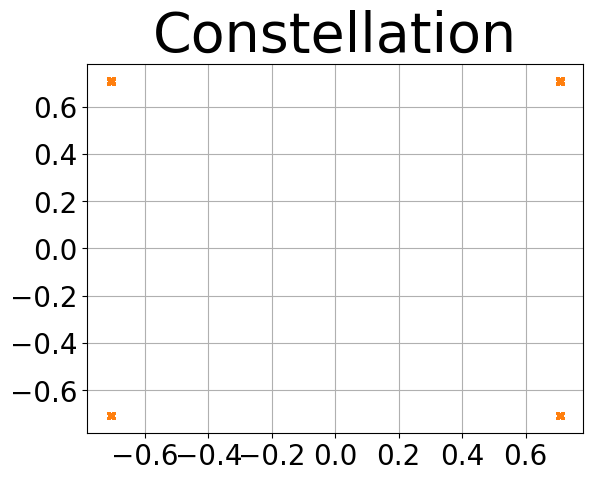

In [86]:
wg.calculate_evm(x[round(wola_len/2):], x_polar[round(wola_len/2):], en_plot=True)